In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.datasets import fashion_mnist
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryPrecision

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [4]:
print(trainX.shape)
print(trainy.shape)
print(testy.shape)

(60000, 28, 28)
(60000,)
(10000,)


In [5]:
class CNNArch5(nn.Module):
  def __init__(self,K):
    super(CNNArch5,self).__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(1,32,3),
        nn.ReLU(),
        nn.Conv2d(32,32,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.25),
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.Conv2d(64,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.25),
    )
    self.deep=nn.Sequential(
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,K)
    )

  def forward(self,X):
    out=self.convs(X)
    #print(out.shape)
    out=out.view(out.size(0),-1)
    out=self.deep(out)
    return out

class CNNArch4(nn.Module):
  def __init__(self,K):
    super(CNNArch4,self).__init__()
    self.convs = nn.Sequential(
        nn.Conv2d(1,64,2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.25),
        nn.Conv2d(64,64,2),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.25),
        nn.Conv2d(64,64,2),
        nn.Dropout(p=0.25)
    )
    self.deep=nn.Sequential(
        nn.Linear(1600,64),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(64, K)
    )
  
  def forward(self,X):
    out=self.convs(X)
    out=out.view(out.size(0),-1)
    out=self.deep(out)
    return out

In [6]:
targets=np.zeros((60000,10))
for j in range(60000):
  targets[j][trainy[j]]=1
targets=torch.tensor(targets)
test_tar=np.zeros((10000,10))
for j in range(10000):
  test_tar[j][testy[j]]=1
test_tar=torch.tensor(test_tar)

In [7]:
class myloader():
    def __init__(self, x,y):
        self.x=x
        self.y=y
        # transform_list += [transforms.Normalize(mean=[0.5], std=[0.5])]
        # preprocess = transforms.Compose(transform_list)
        # self.preprocess = preprocess
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        # t=torch.zeros(10,dtype=torch.float32)
        # t[self.dataset.targets[idx].item()]=1
        # return self.preprocess(self.dataset.data[idx].numpy()), t
        return self.x[idx],self.y[idx]

In [8]:
#model = CNNArch5(10)
model = CNNArch4(10)

In [9]:
device=torch.device("cuda:0"if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNNArch4(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (9): Dropout(p=0.25, inplace=False)
  )
  (deep): Sequential(
    (0): Linear(in_features=1600, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [10]:
trainX=torch.tensor(trainX,dtype=torch.float32)
targets=torch.tensor(targets,dtype=torch.float32)
targets=targets.to(device)
testX=torch.tensor(testX,dtype=torch.float32)
test_tar=torch.tensor(test_tar,dtype=torch.float32)
test_tar=test_tar.to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [11]:
optim=torch.optim.Adam(model.parameters())
#optim=torch.optim.SGD(model.parameters(),lr=0.001)

cri=nn.CrossEntropyLoss()
los_min=10
cur_loss=10
m_los=10

In [12]:
trainX=trainX.unsqueeze(1)
print(trainX.shape)
testX=testX.unsqueeze(1)
print(testX.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [13]:
trainX=trainX.to(device)
testX=testX.to(device)

In [14]:
train_loader = myloader(trainX,targets)
test_loader = myloader(testX,test_tar)

train=torch.utils.data.DataLoader(train_loader,128,True)
test=torch.utils.data.DataLoader(test_loader,128,False)

metric = BinaryF1Score()
metric1 = BinaryAccuracy()
metric2 = BinaryPrecision()

softmax = nn.Softmax(dim=1)

In [15]:
n=50
for epoch in range(n):
  los_train = []
  los_test = []
  f1_list = []
  acc_list = []
  pre_list = []

  model.train()
  for data, target in train:
    optim.zero_grad()
    out=model(data)
    loss=cri(out,target)
    los_train.append(loss.item())
    loss.backward()
    optim.step()

  print(f'epoch {epoch} train loss : {sum(los_train) / len(los_train)}')

  model.eval()
  with torch.no_grad():
    for data, target in test:  
      outt = softmax(model(data))
      cur_loss=cri(outt, target)
      los_test.append(cur_loss.item())

      f1_list.append(metric(outt.cpu(), target.cpu()))
      acc_list.append(metric1(outt.cpu(), target.cpu()))
      pre_list.append(metric2(outt.cpu(), target.cpu()))

    los_test_batch=sum(los_test) / len(los_test)
    f1=sum(f1_list) / len(f1_list)
    acc=sum(acc_list) / len(acc_list)
    pre=sum(pre_list) / len(pre_list)

    if(m_los>los_test_batch):
      print(f'epoch {epoch} Model Saved')
      m_los=los_test_batch
      torch.save(model,'best_model.pth')

    print(f'epoch {epoch} test loss : {los_test_batch}')
    print(f'epoch {epoch} F1 : {f1}')
    print(f'epoch {epoch} Acc : {acc}')
    print(f'epoch {epoch} Pre : {pre}')
    print('*  *  *')

epoch 0 train loss : 0.9055564664701409
epoch 0 Model Saved
epoch 0 test loss : 1.707338256171987
epoch 0 F1 : 0.8085668683052063
epoch 0 Acc : 0.9647646546363831
epoch 0 Pre : 0.8835054039955139
*  *  *
epoch 1 train loss : 0.5343684748545893
epoch 1 Model Saved
epoch 1 test loss : 1.6745961889435974
epoch 1 F1 : 0.8407801389694214
epoch 1 Acc : 0.9702828526496887
epoch 1 Pre : 0.9037508368492126
*  *  *
epoch 2 train loss : 0.47250969622180916
epoch 2 Model Saved
epoch 2 test loss : 1.6685869150523898
epoch 2 F1 : 0.8484274744987488
epoch 2 Acc : 0.9718749523162842
epoch 2 Pre : 0.9179962873458862
*  *  *
epoch 3 train loss : 0.4267474533970168
epoch 3 Model Saved
epoch 3 test loss : 1.6325891380068622
epoch 3 F1 : 0.87298583984375
epoch 3 Acc : 0.9754451513290405
epoch 3 Pre : 0.9035317301750183
*  *  *
epoch 4 train loss : 0.3942962234843769
epoch 4 Model Saved
epoch 4 test loss : 1.6294967418984523
epoch 4 F1 : 0.8770711421966553
epoch 4 Acc : 0.9763745665550232
epoch 4 Pre : 0.91

In [16]:
dict ={0:'T_shirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Boot'}
dict[0]

'T_shirt'

tensor([[  9.5120,  -3.0570,  14.3569,   5.4035,  16.5371, -32.7694,  22.0615,
         -51.9949,  -2.5269, -32.9577]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
it is a Shirt and NN pridected that it is a Shirt


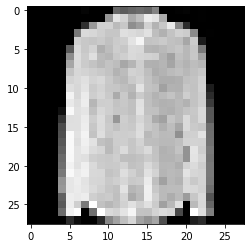

In [17]:
num=44
# x,y=trainX[num],trainy[num]
x,y=testX[num],testy[num]
x=x.unsqueeze(0)
yy=model(x)
x.squeeze(1)
print(yy)
# print(torch.max(yy)==yy)
# print(y)
print(f'it is a {dict[y]} and NN pridected that it is a {dict[int(torch.argmax(yy))]}')
plt.imshow(np.asarray(np.transpose(x.cpu().squeeze(0).squeeze(0),(0,1)),dtype=np.uint8),cmap='gray')

In [18]:
count=0
for i in range(10000):
  # if(i%1000==0):
  #   print(f'i is {i}')
  if(torch.argmax(model(testX[i].unsqueeze(0)))!=testy[i]):
    # print(i)
    # if(count==5):
    #   break
    count+=1
print(count)

903


In [19]:
print(m_los)
print(cur_loss)

1.5751617467856105
tensor(1.5700, device='cuda:0')
